# Collaborative Filtering: Top-$k$ Filtering

## Alex Riley, Apr 23 2018

Thus far, we've looked at weighting user ratings by Pearson correlation coefficient and Cosine similarity.  Here we introduce another concept: top-$k$ filtering.  This is very similar to the prior methods but instead of weighting all users, we only consider the $k$ users most-like our user of interest.

## Load/split data, compute weights

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *

In [2]:
flat_ratings = pd.read_csv('data/ratings.csv',header=0)
ratings_p = flat_ratings.pivot_table(index='userId',columns='movieId',values='rating')

We'll split this into training and test sets, like usual

In [3]:
train_p, test_p = train_test_split(ratings_p, empty=np.nan, testfrac=0.2)

Note that it will be useful to have two versions of the dataframes running around
* Pearson: empty cells filled with NaNs
* Cosine: empty cells filled with 0.0s

In [4]:
ratings_c = ratings_p.fillna(value=0.0)
train_c = train_p.fillna(value=0.0)
test_c = test_p.fillna(value=0.0)

Since the weights will not change with changing $k$, we can also compute those for each method

In [5]:
weights_p = None
weights_c = cosine_sim(train_c)

## Top-$k$ Filtering

In [6]:
def predict_topk(ratings, weights, k=40):
    vals = ratings.values
    pred = np.zeros(vals.shape)
    for i in range(vals.shape[0]):
        # indices of high-weight users, not counting self, descending
        topk_users = [np.argsort(weights[:,i])[-2:-k-2:-1]]
        
        topk_weights = weights[i, :][topk_users]
        sumweights = np.sum(np.abs(topk_weights))
        pred[i] = topk_weights.dot(vals[topk_users])/sumweights
    
    return pd.DataFrame(data=pred, index=ratings.index, columns=ratings.columns)

We compute the top-$k$ filtered results for both the Pearson coefficient weighting

In [7]:
#pred_p = predict_topk(train_p, weights_p)
pred_c = predict_topk(train_c, weights_c)

As before, we can find the MSE of our predictions

In [8]:
#print("Top-k Pearson MSE: " + str(mse(pred_p, test_p)))
print("Top-k Cosine MSE: " + str(mse(pred_c, test_c)))

Top-k Cosine MSE: 8.313358847476218


We can see the MSE was reduced compared to including all users ($MSE_c=10.8$)

## Tuning $k$

We can plot MSE as a function of $k$ in order to see what the optimum $k$ should be for minimizing the MSE

In [9]:
kvals = [2,3,5,6,7,8,10,20,30]
train_c_mse, test_c_mse = [], []

for k in kvals:
    predict_k = predict_topk(train_c, weights_c, k=k)
    train_c_mse.append(mse(predict_k, actual=train_c))
    test_c_mse.append(mse(predict_k, actual=test_c))

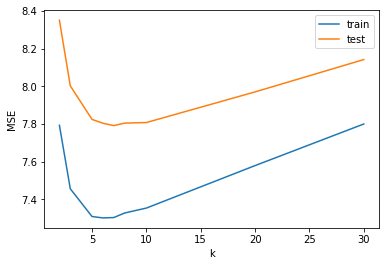

In [10]:
plt.plot(kvals, train_c_mse, label='train')
plt.plot(kvals, test_c_mse, label='test')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend(loc='best');

Optimum k: 7
MSE for k_opt: 7.791027098207985


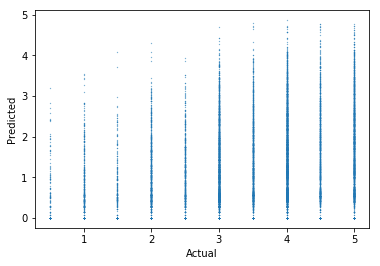

In [11]:
kopt_c = kvals[np.argmin(test_c_mse)]
pred_kopt_c = predict_topk(train_c, weights_c, k=kopt_c)

print("Optimum k: " + str(kopt_c))
print("MSE for k_opt: " + str(test_c_mse[np.argmin(test_c_mse)]))

plt.plot(test_c.values[test_c.values > 0], pred_kopt_c.values[test_c.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

We see that this prediction is less biased towards underestimating the actual rating, though it still has a massive smear across the parameter space.